In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandits_final

In [2]:
np.random.seed(0)

In [3]:
def decaying_epsilon_greedy(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, alpha=-1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k)  # number of times each action was taken

    rewards = []
    optimal_action_counts = np.zeros(num_steps)

    epsilon = epsilon_start

    for t in range(num_steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(0, k)  # exploration
        else:
            action = np.argmax(Q)  # exploitation

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        N[action] += 1
        # if alpha is -1, the step size is dynamic, averaging the rewards;
        # with constant alpha, each reward has equal weight, with increased response to recent rewards.
        step_size = 1 / N[action] if alpha == -1 else alpha
        Q[action] += step_size * (reward - Q[action])

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return rewards, percent_optimal_actions

In [4]:
def ucb(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, c=1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k) + 1e-10  # number of times each action was taken (avoid div by zero)

    rewards = []
    optimal_action_counts = np.zeros(num_steps)

    epsilon = epsilon_start

    for t in range(num_steps):
        confidence_bound = c * np.sqrt(np.log(t + 1) / N)
        action = np.argmax(Q + confidence_bound)

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return rewards, percent_optimal_actions

In [5]:
def d_ucb(mab, num_steps=5000, gamma=0.99, c=1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k) + 1e-10  # number of times each action was taken (avoid div by zero)

    rewards = []
    optimal_action_counts = np.zeros(num_steps)

    for t in range(1, num_steps + 1):
        if t <= k:
            action = t - 1  # Initial phase: play each arm once
        else:
            # Calculate the upper confidence bounds with discounting
            n_t = sum(N)  # Total discounted count
            confidence_bound = (c * np.sqrt(np.log(n_t) / N))
            action = np.argmax(Q + confidence_bound)  # Select the arm with the highest upper confidence bound

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t - 1] = 1  # mark as optimal

        # Apply discount to the number of selections
        N *= gamma
        N[action] += 1  # Increment the count for the selected arm

        # Update estimated values with discounting
        Q *= gamma
        Q[action] += (reward - Q[action]) / N[action]

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return rewards, percent_optimal_actions

In [6]:
def run_bandit_simulation(strategy_func, num_runs=500, num_steps=5000, **strategy_kwargs):
    avg_reward = np.zeros(num_steps)
    avg_optimal_actions = np.zeros(num_steps)

    for run in range(num_runs):
        mab = Bandits_final()
        rewards, percent_optimal_actions = strategy_func(mab, num_steps=num_steps, **strategy_kwargs)
        avg_reward += rewards
        avg_optimal_actions += percent_optimal_actions

    avg_reward /= num_runs
    avg_optimal_actions /= num_runs
    return avg_reward, avg_optimal_actions

In [7]:
step_sizes = [-1, 0.01, 0.1, 0.15, 0.25, 0.5, 0.75, 1]
dec_eps_greedy_simulation_results = [run_bandit_simulation(strategy_func=decaying_epsilon_greedy, alpha=step_size) for
                                     step_size in step_sizes]

In [8]:
c_values = [0.5, 1, 2, 3]
ucb_simulation_results = [run_bandit_simulation(strategy_func=ucb, c=c) for c in c_values]

In [9]:
c_values = [0.5, 1, 2, 3]
d_ucb_simulation_results = [run_bandit_simulation(strategy_func=d_ucb, c=c) for c in c_values]

In [10]:
def plot_simulation_results(simulation_results, labels):
    cmap = plt.get_cmap("tab20b")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first set of results
    for i, (avg_reward, percent_optimal_actions) in enumerate(simulation_results):
        label = labels[i]
        ax1.plot(avg_reward, label=label, color=cmap(i / len(simulation_results)))
        ax2.plot(percent_optimal_actions, label=label, color=cmap(i / len(simulation_results)))

    ax1.set_title("Average Reward")
    ax1.set_ylabel("Average Reward")
    ax1.set_xlabel("Steps")
    ax1.grid(color='silver', linestyle="--", linewidth=0.5)
    ax1.legend()

    ax2.set_title("Percentage of Optimal Actions")
    ax2.set_ylabel("Optimal Action %")
    ax2.set_xlabel("Steps")
    ax2.grid(color='silver', linestyle='--', linewidth=0.5)
    ax2.legend()

    plt.tight_layout()
    plt.show()

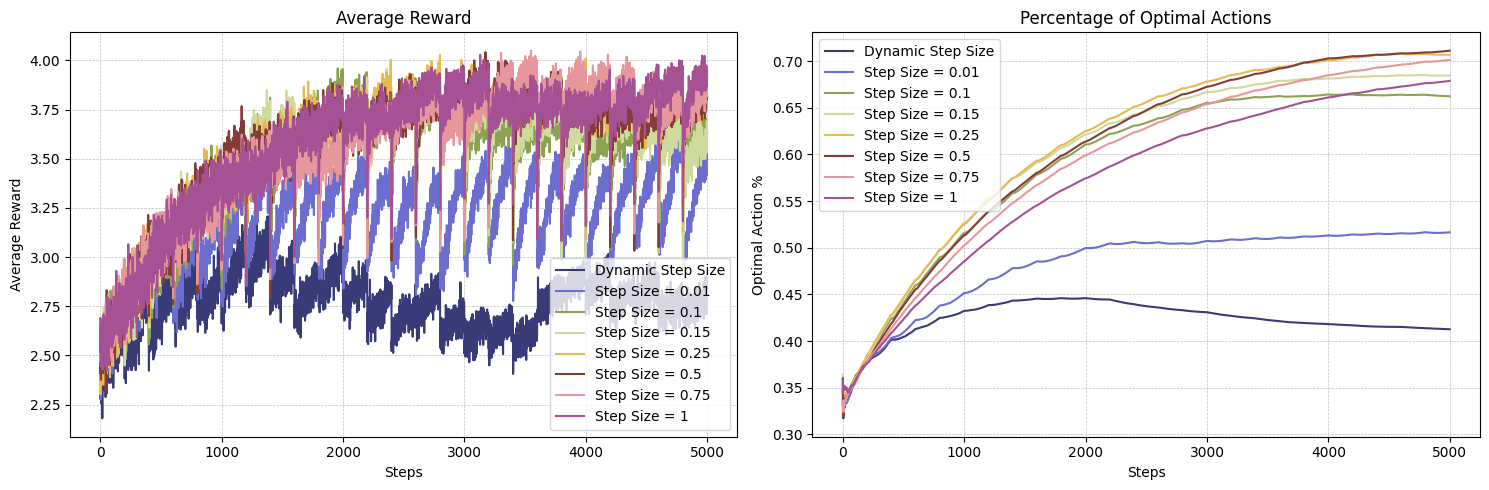

In [11]:
dec_eps_greedy_simulation_labels = ["Dynamic Step Size" if alpha == -1 else f"Step Size = {alpha}" for alpha in
                                    step_sizes]
plot_simulation_results(dec_eps_greedy_simulation_results, dec_eps_greedy_simulation_labels)

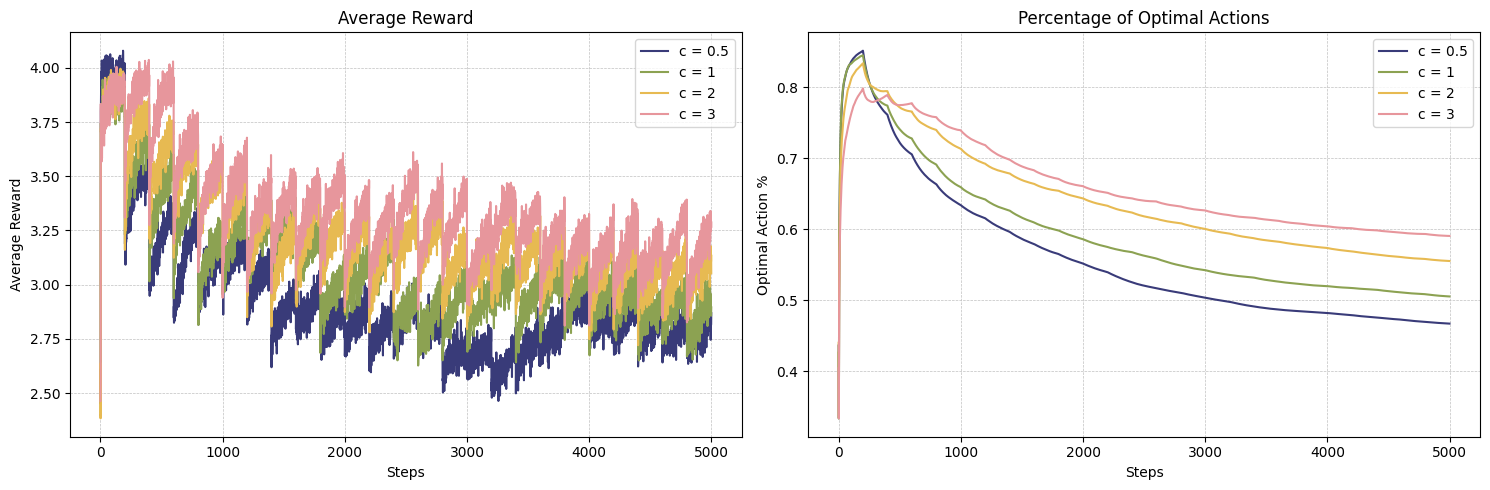

In [12]:
ucb_labels = [f"c = {c}" for c in c_values]
plot_simulation_results(ucb_simulation_results, ucb_labels)

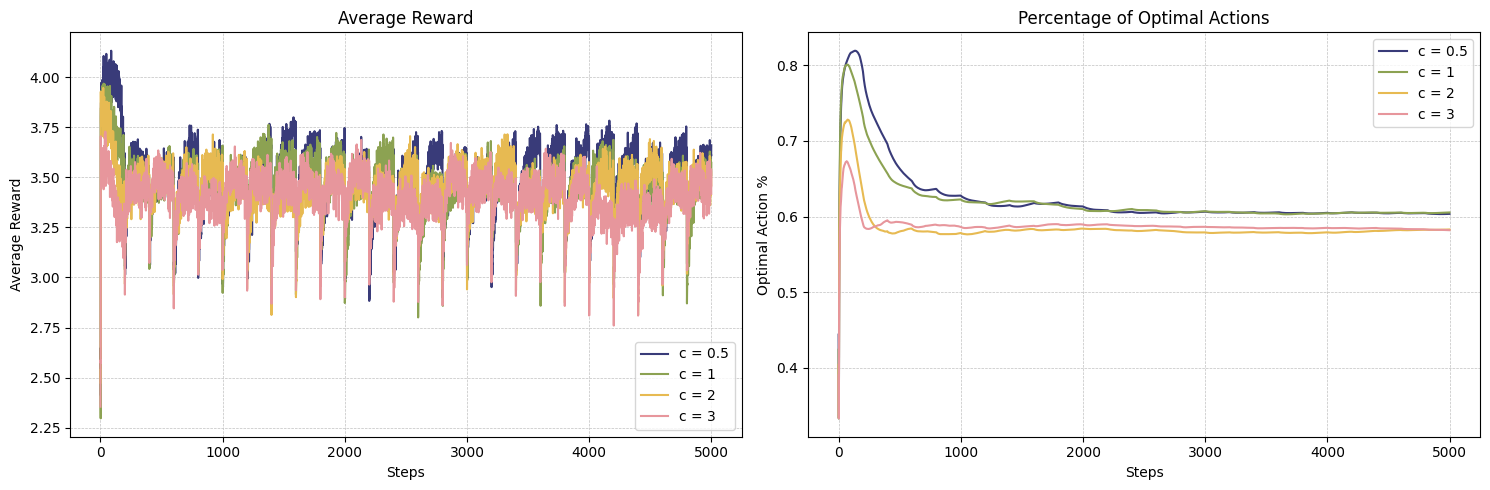

In [13]:
plot_simulation_results(d_ucb_simulation_results, ucb_labels)